In [1]:
import networkx as nx
import pandas as pd
import numpy as np

import dgl
import dgl.nn as gnn

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import random
random.seed(0)
np.random.seed(0)

### Task 1

Задание 1. Загрузите датасет `CoraGraphDataset` из `dgl.data`. Этот датасет состоит из одного графа. Выведите на экран:

* количество узлов в графе;
* количество ребер в графе;
* размерность атрибутов на узлах;
* количество классов узлов в датасете

Выделите подграф (`dgl.node_subgraph`), содержащий узлы, относящиеся к трем наиболее часто встречающимся классам. __1 балл__

In [4]:
dataset = dgl.data.CoraGraphDataset()
graph = dataset[0]

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [5]:
f'число узлов в графе: {graph.num_nodes()},  число ребер: {graph.num_edges()}, размерность атрибутов: {graph.ndata["feat"].shape[1]}, число классов: {dataset.num_classes}'

'число узлов в графе: 2708,  число ребер: 10556, размерность атрибутов: 1433, число классов: 7'

In [6]:
### Найдем классы, которые встречаются в датасете чаще всего
labels, counts = graph.ndata['label'].unique(return_counts=True)
most_frequent = labels[counts.sort(descending=True).indices][:3] ### Три наиболее часто встречающихся
nodes_idx = torch.arange(0,graph.num_nodes(), dtype=torch.int64)[torch.isin(graph.ndata['label'], most_frequent)]

In [7]:
### Выделим подграф
subgraph = graph.subgraph(nodes_idx)
subgraph

Graph(num_nodes=1662, num_edges=5708,
      ndata_schemes={'feat': Scheme(shape=(1433,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool), 'train_mask': Scheme(shape=(), dtype=torch.bool), '_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)})

In [8]:
graph

Graph(num_nodes=2708, num_edges=10556,
      ndata_schemes={'feat': Scheme(shape=(1433,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool), 'train_mask': Scheme(shape=(), dtype=torch.bool)}
      edata_schemes={})

### Task 2

Задание 2. Файл `cities_nodes.csv` содержит данные о городах: название, страна, население, дату основания и координаты. В файле `cities_edges.csv` содержатся данные о связях между городам: города соединяются ребрами в случае, если в статье русскоязычной Википедии о городе присутсвует ссылка на страницу для другого города. Создайте на основе двух этих файлов `dgl.graph`. Для этого:


1. занумеруйте города (узлы) целыми числами;

2. представьте каждое ребро в виде пары двух целых чисел;

3. в качестве атрибутов (`g.ndata['feat']`) узлов используйте логарифм численности населения в городе и входящую степень узлов (результат сохраните в виде двумерного тензора размера `(n_nodes, 2)` и приведите к `torch.float32`);

4. занумеруйте страны целыми числами и в качестве меток узлов (`g.ndata['label']`) используйте номер соотвествующей страны; используйте тензор типа `torch.int64`;

5. в качестве атрибутов (`g.edata['distance']`) ребер используйте логарифм расстояния между городами (результат сохраните в виде одномерного тензора размера `(n_edges, )` и приведите к `torch.float32`);

6. добавьте графу атрибут `num_classes`, в котором хранится число классов (стран);

7. разбейте множество узлов на обучающее и валидационное множество в соотношении 90%-10%. Для представления каждого из множеств создайте булев тензор $t$ размерности, равной количеству узлов в графе, где $t[i]==True$, если узел $i$ входит в соответствующее множество. Добавьте в словарь `ndata` два ключа `train_mask`, `val_mask`. __(1 балл)__


In [9]:
cities_nodes = pd.read_csv('cities_nodes.csv')
cities_edges = pd.read_csv('cities_edges.csv')

In [10]:
cities_nodes = cities_nodes.rename(columns={'Unnamed: 0': 'city'})
cities_nodes.head()

,city,country_label,population,inception,lat,long
0,Минск,Белоруссия,2009786,01.01.1067,27.561837,53.902246
1,Гомель,Белоруссия,510300,01.01.1142,30.983333,52.441667
2,Брест,Белоруссия,340318,01.01.1017,23.656944,52.084722
3,Гродно,Белоруссия,356900,01.01.1128,23.816667,53.666667
4,Вилейка,Белоруссия,27167,25.11.1460,26.916667,54.483333


In [11]:
cities_edges.head()

,source,target,distance
0,Минск,Новополоцк,125.318358
1,Минск,Могилёв,191.535637
2,Минск,Слуцк,54.352190
3,Минск,Барановичи,119.025908
4,Минск,Бобруйск,123.884508


In [12]:
### Занумеруем города целыми числами

In [13]:
from sklearn.preprocessing import LabelEncoder

In [14]:
### Занумеруем города
le_city = LabelEncoder()
le_city.fit(cities_nodes.city)
cities_nodes.city = le_city.transform(cities_nodes.city)
cities_edges.source = le_city.transform(cities_edges.source)
cities_edges.target = le_city.transform(cities_edges.target)
### Занумеруем страны
le_country = LabelEncoder()
le_country.fit(cities_nodes.country_label)
cities_nodes.country_label = le_country.transform(cities_nodes.country_label)

In [15]:
cities_nodes.head()

,city,country_label,population,inception,lat,long
0,185,1,2009786,01.01.1067,27.561837,53.902246
1,72,1,510300,01.01.1142,30.983333,52.441667
2,43,1,340318,01.01.1017,23.656944,52.084722
3,76,1,356900,01.01.1128,23.816667,53.666667
4,54,1,27167,25.11.1460,26.916667,54.483333


In [16]:
cities_edges.head()

,source,target,distance
0,185,202,125.318358
1,185,188,191.535637
2,185,242,54.352190
3,185,26,119.025908
4,185,40,123.884508


In [17]:
### Создадим граф на основе информации из cities_edges
### Граф делаем заведомо ненаправленным
cities_graph = dgl.graph(data=tuple(torch.tensor(x) for x in cities_edges[['source', 'target']].values.transpose()),
          num_nodes=len(cities_nodes.city))
cities_graph = dgl.to_bidirected(cities_graph)
### Добавим каждому городу из cities_nodes информацию по входящей степени соответствующего узла
for_degree_count = cities_edges.rename(columns={'source':'target', 'target':'source'})
degrees = for_degree_count.groupby('source', as_index=False).target.apply(lambda x: len(list(x)))
degrees = degrees.rename(columns={'source':'city', 'target': 'degree'})
cities_nodes = cities_nodes.merge(degrees, on='city')
cities_graph.ndata['feats'] = torch.log(torch.tensor(cities_nodes.sort_values('city')[['population', 'degree']].values)).float()
### Добавим информацию о лейблах (странах)
cities_graph.ndata['label'] = torch.tensor(cities_nodes.sort_values('city').country_label.values).long()

In [18]:
### Поскольку теперь граф ненаправленный, нужно добавить информацию о зеркальных ребрах
for_degree_count = pd.concat((cities_edges, cities_edges\
                              .rename(columns={'source':'target', 'target':'source'}))).drop_duplicates()
### Добавим в граф информацию о ребрах
edges_info = pd.DataFrame(np.array([x.numpy() for x in cities_graph.edges()]).transpose())
edges_info.columns = ['source', 'target']
edges_info = edges_info.merge(for_degree_count, how='left', on=['source', 'target'])
### Добавим единицу к расстоянию, чтобы нулевое значение не давало -бесконечность, что не даст считать лосс
cities_graph.edata['distance'] = torch.log(torch.tensor(edges_info.distance)+1).float()

In [19]:
### Добавим в класс описывающий граф аттрибут label, который показывает, сколько уникальных лейблов в датасете
cities_graph.num_classes = torch.unique(cities_graph.ndata['label']).shape[0]

In [20]:
### Разобьем все узлы на трейн и тест 90/10

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
train_cities, test_cities = train_test_split(cities_nodes.city.values, test_size=0.1, shuffle=True, random_state=42)

In [23]:
train_mask = torch.isin(cities_graph.nodes(), torch.tensor(train_cities))
test_mask = torch.isin(cities_graph.nodes(), torch.tensor(test_cities))

In [24]:
cities_graph.ndata['train_mask'] = train_mask
cities_graph.ndata['val_mask'] = test_mask

### Task 3

Задание 3. Используя граф, полученный в задании 2, и графовую нейронную сеть, написанную с использованием библиотеки `dgl`, решите задачу классификации городов по странам (задача классификации узлов). __(2 балла)__

На каждой эпохи обучения выводите на экран следующую информацию:
1. Номер эпохи
2. Значение функции потерь на обучающем множестве
3. Значение метрики accuracy (`sklearn.metrics.accuracy_score`) на обучающем множестве
3. Значение метрики accuracy (`sklearn.metrics.accuracy_score`) на тестовом множестве

Важно: при расчете значения функции потерь при обучении используйте только узлы, относящиеся к обучающему множеству! Узлы, относящиеся к валидационному множеству, для простоты можно оставить в графе, но прогнозы для этих узлов не должны оказывать влияние на функцию потерь и обратное распространение ошибки при обучении.

##### Напишем базовый класс нейронной сети
 - Выходная размерность будет равна кол-ву классов
 - Аналогично примеру будут использованы две свертки
 - Функция активации между свертками релу

In [25]:
from dgl.nn import GraphConv, EGATConv
from sklearn.metrics import accuracy_score

In [26]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)
dgl.random.seed(0)

In [27]:
class BaseModel(nn.Module):
    def __init__(self, in_features, h_features, num_classes):
        super().__init__()
        self.conv1 = GraphConv(in_features, h_features)
        self.conv2 = GraphConv(h_features, num_classes)
        self.relu = nn.ReLU()
        self.batch_norm1 = nn.BatchNorm1d(in_features)
        self.batch_norm2 = nn.BatchNorm1d(h_features)
    def forward(self, graph):
        normed_in_feats = graph.ndata['feats']
        g, feats = graph, normed_in_feats
        x = self.conv1(g, feats)
        x = self.relu(x)
        x = self.batch_norm2(x)
        x = self.conv2(g, x)
        return x

In [28]:
def get_loss(true, pred):
    loss = nn.CrossEntropyLoss()
    return loss(pred, true)

In [29]:
class CFG:
    NUM_EPOCHS = 70
    LR = 1e-3

In [30]:
model = BaseModel(2, 300, 4).cpu()
optimizer = torch.optim.Adam(model.parameters(), lr=CFG.LR)

In [31]:
cities_graph = cities_graph.cpu()

In [32]:
cities_graph.subgraph(cities_graph.nodes()[cities_graph.ndata['train_mask']])

Graph(num_nodes=283, num_edges=10452,
      ndata_schemes={'feats': Scheme(shape=(2,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64), 'train_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool), '_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'distance': Scheme(shape=(), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)})

In [33]:
for epoch in range(CFG.NUM_EPOCHS):
    ### Считаем обучающую выбоку
    model.train(True)
    model.zero_grad()
    preds = model(cities_graph)
    loss_val = get_loss(cities_graph.ndata['label'][cities_graph.ndata['train_mask']],
                        preds[cities_graph.ndata['train_mask']])
    loss_val.backward()
    optimizer.step()

    train_score = accuracy_score(cities_graph.ndata['label'].cpu().detach().numpy()[cities_graph.ndata['train_mask']],
                                 torch.argmax(preds.cpu(), dim=1).detach().numpy()[cities_graph.ndata['train_mask']])

    val_score = accuracy_score(cities_graph.ndata['label'].cpu().detach().numpy()[cities_graph.ndata['val_mask']],
                                 torch.argmax(preds.cpu(), dim=1).detach().numpy()[cities_graph.ndata['val_mask']])


    print(f'epoch:{epoch}, loss: {loss_val.item()}, train_acc: {train_score}, val_acc:{val_score}')

epoch:0, loss: 1.4778393507003784, train_acc: 0.31448763250883394, val_acc:0.28125
epoch:1, loss: 1.2692971229553223, train_acc: 0.4134275618374558, val_acc:0.34375
epoch:2, loss: 1.0863442420959473, train_acc: 0.7526501766784452, val_acc:0.71875
epoch:3, loss: 0.951263427734375, train_acc: 0.7773851590106007, val_acc:0.71875
epoch:4, loss: 0.8251751661300659, train_acc: 0.784452296819788, val_acc:0.75
epoch:5, loss: 0.7451438903808594, train_acc: 0.784452296819788, val_acc:0.75
epoch:6, loss: 0.6826397776603699, train_acc: 0.784452296819788, val_acc:0.75
epoch:7, loss: 0.6288027167320251, train_acc: 0.784452296819788, val_acc:0.78125
epoch:8, loss: 0.6046380400657654, train_acc: 0.7879858657243817, val_acc:0.75
epoch:9, loss: 0.5530614852905273, train_acc: 0.9646643109540636, val_acc:1.0
epoch:10, loss: 0.5238933563232422, train_acc: 0.9752650176678446, val_acc:1.0
epoch:11, loss: 0.5049781203269958, train_acc: 0.9752650176678446, val_acc:1.0
epoch:12, loss: 0.48304522037506104, train

### Task 4

Задание 4. Используя граф, полученный в задании 2, и графовую нейронную сеть, написанную с использованием библиотеки `dgl`, решите задачу предсказания связей. __(2 балла)__

Цикл обучения должен состоять из следующих шагов:
1. получение представлений `h` узлов при помощи сети, аналогичной заданию 3;
2. конструирование графа отрицательных примеров (см функцию `construct_negative_graph`);
3. расчет прогнозов ребер на основе исходного графа и скрытых представлений узлов `h` (см класс `MLPPredictor`) - для этих ребер модель должна предсказывать метку 1;
4. расчет прогнозов ребер на основе графа отрицательных примеров и и скрытых представлений узлов `h` (см класс `MLPPredictor`) - для этих ребер модель должна предсказывать метку 0;
5. расчет функции потерь (например, `CrossEntropyLoss`) и шаг оптимизации.

На каждой эпохи обучения выводите на экран следующую информацию:
1. Номер эпохи;
2. Значение функции потерь на обучающем множестве.

Примечания:
1. для простоты в данной задаче не предполагается разбиение ребер на обучающее и тестовое множество;
2. на каждой эпохе получение эмбеддингов `h` происходит только 1 раз на основе исходного графа;

In [34]:
### Сгенерируем негативный граф при помощи изначальной функции
def construct_negative_graph(g, k):
    '''Берет ребра из графа g и случайным образом заменяет вершины на концах ребер'''
    u, v = g.edges()
    neg_u = u.repeat_interleave(k).long()
    neg_v = torch.randint(0, g.num_nodes(), (len(neg_u),)).long()
    return dgl.graph((neg_u, neg_v), num_nodes=g.num_nodes())

In [35]:
neg_graph = construct_negative_graph(cities_graph, 1)

In [36]:
### Данная методика, к сожалению, не дает реальный граф отрицательных ребер. Убедимся в этом исследовав всего 20 ребер

In [37]:
neg = torch.cat((neg_graph.edges()[0].unsqueeze(0), neg_graph.edges()[1].unsqueeze(0)), dim=0).t()
pos = torch.cat((cities_graph.edges()[0].unsqueeze(0), cities_graph.edges()[1].unsqueeze(0)), dim=0).t()

In [38]:
k = 0
for p in pos[:20]:
    for n in neg:
        if p[0]==n[0] and p[1]==n[1]:
            k+=1
            print(p, n)
print(k)

tensor([0, 2]) tensor([0, 2])
tensor([ 0, 17]) tensor([ 0, 17])
tensor([ 0, 17]) tensor([ 0, 17])
tensor([ 0, 21]) tensor([ 0, 21])
tensor([ 0, 70]) tensor([ 0, 70])
tensor([ 0, 70]) tensor([ 0, 70])
6


In [39]:
### Используем встроенный в dgl negative sampler

In [40]:
neg_sampler = dgl.dataloading.negative_sampler.GlobalUniform(cities_graph.edges()[0].shape[0]//2, True)

In [41]:
neg_graph = dgl.graph(neg_sampler(cities_graph, torch.tensor([0,1], dtype=torch.long)), num_nodes=cities_graph.num_nodes())

In [42]:
neg_graph

Graph(num_nodes=315, num_edges=13116,
      ndata_schemes={}
      edata_schemes={})

In [43]:
cities_graph

Graph(num_nodes=315, num_edges=13117,
      ndata_schemes={'feats': Scheme(shape=(2,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64), 'train_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool)}
      edata_schemes={'distance': Scheme(shape=(), dtype=torch.float32)})

In [44]:
### Используем класс аналогичный тому, что использовали в прошлом задании для того, чтобы получать эмбеддинги изначального графа
### При этом нельзя использовать свертки, которые учитывают информацию ребер, поскольку такая модель не имеет смысла

In [45]:
import itertools ### Необходимо для работы оптимизатора с весами нескольких моделей

In [46]:
class GetEmbedding(nn.Module):
    def __init__(self, in_features, hidden_state):
        super().__init__()
        self.conv1 = GraphConv(in_features, hidden_state*2)
        self.conv2 = GraphConv(hidden_state*2, hidden_state)
        self.relu = nn.ReLU()
        self.batch_norm1 = nn.BatchNorm1d(in_features)
        self.batch_norm2 = nn.BatchNorm1d(hidden_state*2)
    def forward(self, graph):
        normed_in_feats = graph.ndata['feats']
        g, feats = graph, normed_in_feats
        x = self.conv1(g, feats)
        x = self.relu(x)
        x = self.batch_norm2(x)
        x = self.conv2(g, x)
        return x

In [47]:
class MLPPredictor(nn.Module):
    '''Берет представления узлов, находящихся на концах ребер, конкатенирует их и прогоняет через небольшую полносвязную
    сеть для получения прогноза вероятности существования ребра'''
    def __init__(self, h_feats, out_feats=1):
        super().__init__()
        self.W1 = nn.Linear(h_feats * 2, h_feats)
        self.W2 = nn.Linear(h_feats, out_feats)

    def apply_edges(self, edges):
        h = torch.cat([edges.src['h'], edges.dst['h']], 1)
        return {'score': self.W2(F.relu(self.W1(h))).squeeze(1)}

    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(self.apply_edges)
            return g.edata['score']

In [48]:
def get_loss(true, pred):
    criterion = nn.BCEWithLogitsLoss()
    return criterion(pred, true)

In [49]:
class CFG:
    hidden_dim = 100
    num_epochs=200

In [50]:
ge = GetEmbedding(2, CFG.hidden_dim).cpu()
mpp = MLPPredictor(CFG.hidden_dim, 1).cpu()
optimizer = torch.optim.Adam(itertools.chain(ge.parameters(), mpp.parameters()), lr=1e-3)

In [51]:
for epoch in range(CFG.num_epochs):
    optimizer.zero_grad()
    hidden_states = ge(cities_graph)
    pos_preds = mpp(cities_graph, hidden_states)
    neg_preds = mpp(neg_graph, hidden_states)
    loss_val = get_loss(torch.ones_like(pos_preds), pos_preds) + get_loss(torch.zeros_like(neg_preds), neg_preds)
    loss_val.backward()
    optimizer.step()
    print(f'epoch {epoch}, loss_value {loss_val}')

epoch 0, loss_value 1.3843879699707031
epoch 1, loss_value 1.2922371625900269
epoch 2, loss_value 1.2231252193450928
epoch 3, loss_value 1.1719220876693726
epoch 4, loss_value 1.1310232877731323
epoch 5, loss_value 1.0967767238616943
epoch 6, loss_value 1.0645248889923096
epoch 7, loss_value 1.0332748889923096
epoch 8, loss_value 1.0020067691802979
epoch 9, loss_value 0.9687840342521667
epoch 10, loss_value 0.9349908232688904
epoch 11, loss_value 0.9027582406997681
epoch 12, loss_value 0.8719193935394287
epoch 13, loss_value 0.8423999547958374
epoch 14, loss_value 0.8142914772033691
epoch 15, loss_value 0.7870649099349976
epoch 16, loss_value 0.7610523700714111
epoch 17, loss_value 0.7369312047958374
epoch 18, loss_value 0.7150522470474243
epoch 19, loss_value 0.6960963606834412
epoch 20, loss_value 0.6802425384521484
epoch 21, loss_value 0.6672406196594238
epoch 22, loss_value 0.6553478240966797
epoch 23, loss_value 0.644800066947937
epoch 24, loss_value 0.6352438926696777
epoch 25, l

### Task 5

Задание 5. Используя граф, полученный в задании 2, и графовую нейронную сеть, написанную с использованием библиотеки `dgl`, решите задачу предсказания расстояния между городами (задача регрессии на ребрах). __(2 балла)__

Цикл обучения должен состоять из следующих шагов:
1. получение представлений `h` узлов при помощи сети, аналогичной заданию 3;
3. расчет прогнозов ребер на основе исходного графа и скрытых представлений узлов `h` (см класс `MLPPredictor`);
5. расчет функции потерь (например, `MSELoss`) и шаг оптимизации.

На каждой эпохи обучения выводите на экран следующую информацию:
1. Номер эпохи
2. Значение функции потерь на обучающем множестве.

Примечание: для простоты в данной задаче не предполагается разбиение ребер на обучающее и тестовое множество.

In [52]:
### Решение данной задачи сводится к упрощению предыдущей задачи

In [53]:
class GetEmbedding(nn.Module):
    def __init__(self, in_features, hidden_state):
        super().__init__()
        self.conv1 = GraphConv(in_features, hidden_state*2)
        self.conv2 = GraphConv(hidden_state*2, hidden_state)
        self.relu = nn.ReLU()
        self.batch_norm1 = nn.BatchNorm1d(in_features)
        self.batch_norm2 = nn.BatchNorm1d(hidden_state*2)
    def forward(self, graph):
        normed_in_feats = graph.ndata['feats']
        g, feats = graph, normed_in_feats
        x = self.conv1(g, feats)
        x = self.relu(x)
        x = self.batch_norm2(x)
        x = self.conv2(g, x)
        return x

In [54]:
class MLPPredictor(nn.Module):
    '''Берет представления узлов, находящихся на концах ребер, конкатенирует их и прогоняет через небольшую полносвязную
    сеть для получения прогноза вероятности существования ребра'''
    def __init__(self, h_feats, out_feats=1):
        super().__init__()
        self.W1 = nn.Linear(h_feats * 2, h_feats)
        self.W2 = nn.Linear(h_feats, out_feats)

    def apply_edges(self, edges):
        h = torch.cat([edges.src['h'], edges.dst['h']], 1)
        return {'score': self.W2(F.relu(self.W1(h))).squeeze(1)}

    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(self.apply_edges)
            return g.edata['score']

In [55]:
def get_loss(true, pred):
    criterion = nn.MSELoss()
    return criterion(pred, true)

In [56]:
class CFG:
    hidden_dim = 100
    num_epochs=200

In [57]:
ge = GetEmbedding(2, CFG.hidden_dim).cpu()
mpp = MLPPredictor(CFG.hidden_dim, 1).cpu()
optimizer = torch.optim.Adam(itertools.chain(ge.parameters(), mpp.parameters()), lr=1e-3)

In [58]:
for epoch in range(CFG.num_epochs):
    optimizer.zero_grad()
    hidden_states = ge(cities_graph)
    preds = mpp(cities_graph, hidden_states)
    loss_val = get_loss(cities_graph.edata['distance'], preds)
    loss_val.backward()
    optimizer.step()
    print(f'epoch {epoch}, loss_value {loss_val}')

epoch 0, loss_value 20.880924224853516
epoch 1, loss_value 19.184555053710938
epoch 2, loss_value 17.78626823425293
epoch 3, loss_value 16.44331932067871
epoch 4, loss_value 15.065906524658203
epoch 5, loss_value 13.618638038635254
epoch 6, loss_value 12.08454704284668
epoch 7, loss_value 10.46723747253418
epoch 8, loss_value 8.80892276763916
epoch 9, loss_value 7.176604747772217
epoch 10, loss_value 5.631616115570068
epoch 11, loss_value 4.286076068878174
epoch 12, loss_value 3.263427257537842
epoch 13, loss_value 2.670363426208496
epoch 14, loss_value 2.5767626762390137
epoch 15, loss_value 2.887181043624878
epoch 16, loss_value 3.2854158878326416
epoch 17, loss_value 3.4615559577941895
epoch 18, loss_value 3.21551775932312
epoch 19, loss_value 2.650847911834717
epoch 20, loss_value 2.2021706104278564
epoch 21, loss_value 1.8411809206008911
epoch 22, loss_value 1.7076934576034546
epoch 23, loss_value 1.712902545928955
epoch 24, loss_value 1.7716137170791626
epoch 25, loss_value 1.795

### Task 6

Задание 6. Сведите эмбеддинги узлов, полученные при обучении модели в задаче 5, к векторам размерности 2, используя метод главных компонент (`sklearn.decomposition.PCA`). Визуализируйте сеть, используя теперь для координат точек векторное представление узлов размерности 2. Покажите цветом узла страну, к которой относится город. __(1 балл)__

Для преобразования `DGLGraph` к `nx.Graph` можно воспользоваться функцией `dgl.to_networkx`.

In [67]:
from sklearn.decomposition import PCA

In [68]:
np_states = hidden_states.detach().numpy()
np_states_2d = PCA(2).fit_transform(np_states)

In [69]:
nx_graph = dgl.to_networkx(cities_graph)

In [70]:
colors = ['red', 'blue', 'green', 'yellow']
colormap = [colors[x] for x in cities_graph.ndata['label']]

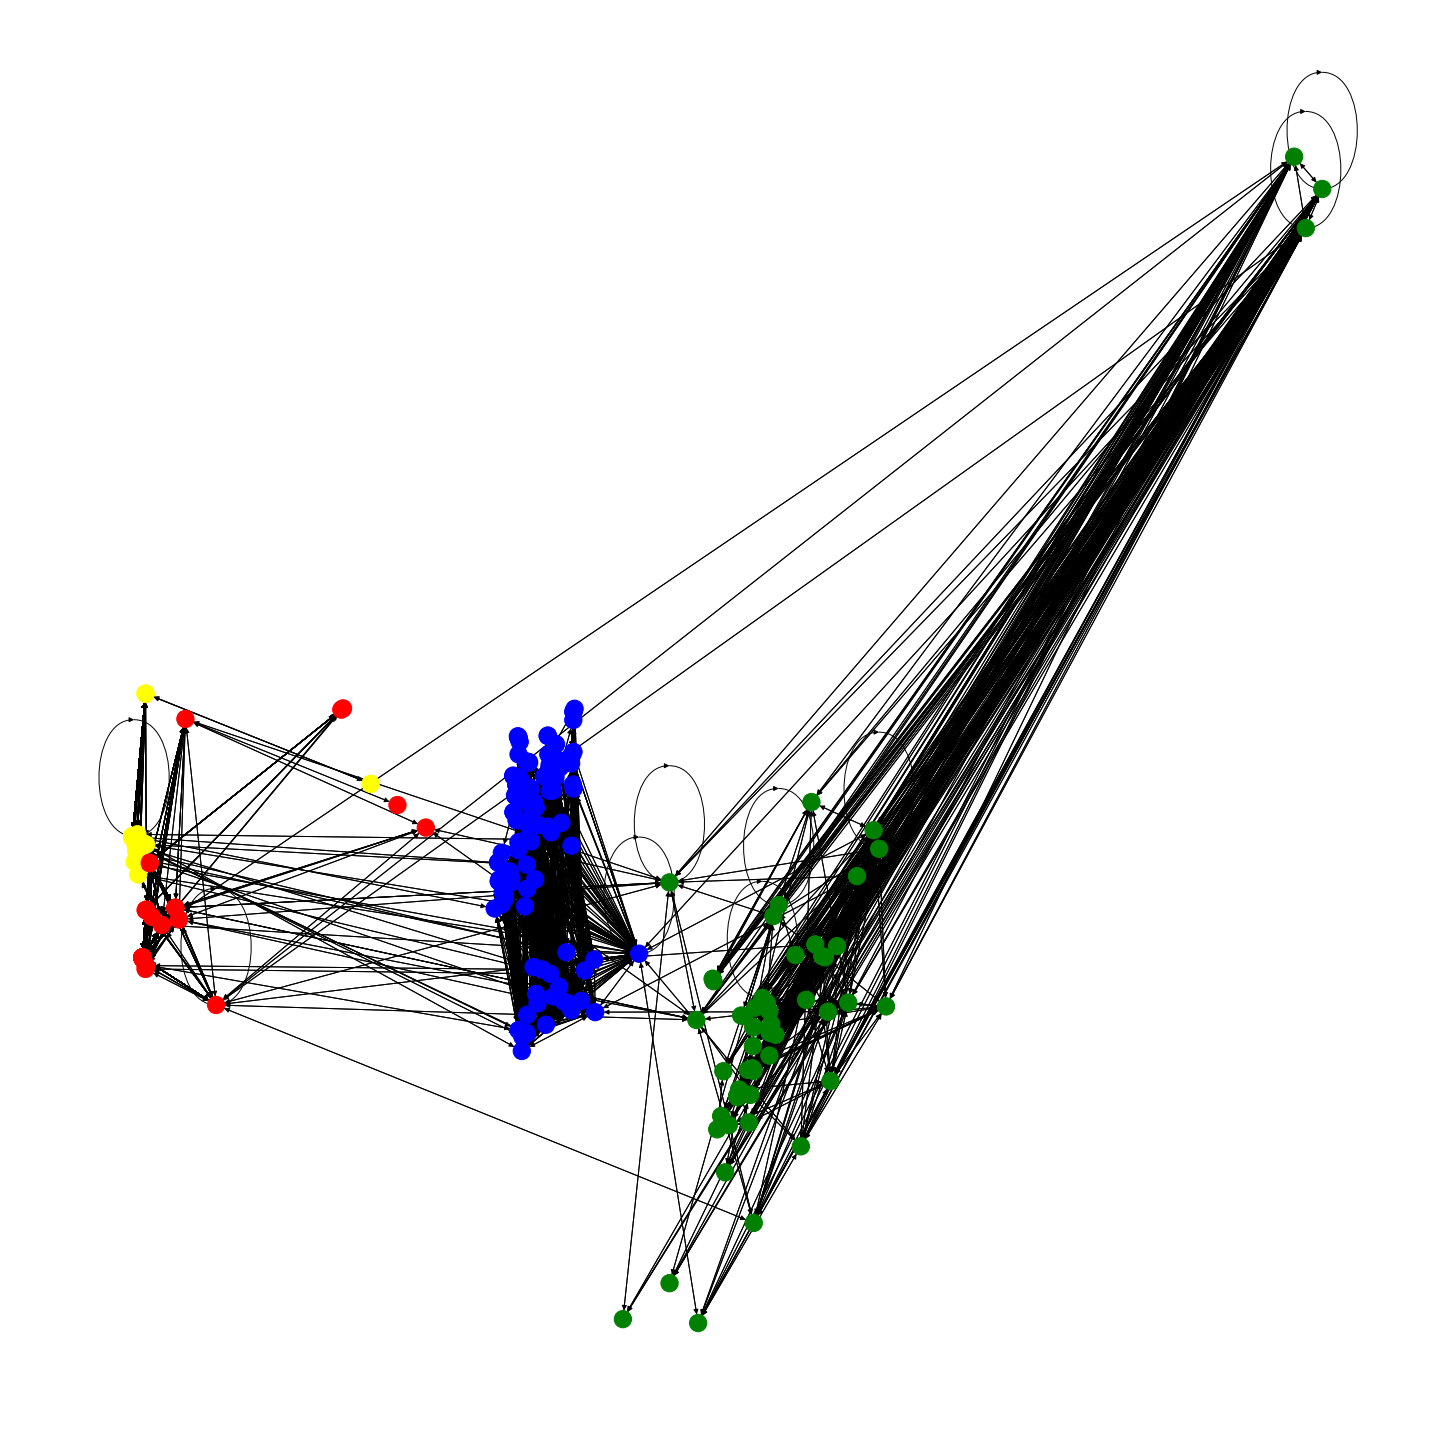

In [71]:
plt.figure(figsize=(20, 20))
nx.draw(nx_graph, np_states_2d, node_color=colormap)

In [72]:
### Для сравнения визуализируем изначальные данные

In [73]:
cities_nodes[['population', 'degree']]

,population,degree
0,2009786,78
1,510300,44
2,340318,46
3,356900,37
4,27167,25
...,...,...
310,12418,3
311,19127,6
312,45004,5
313,26574,4


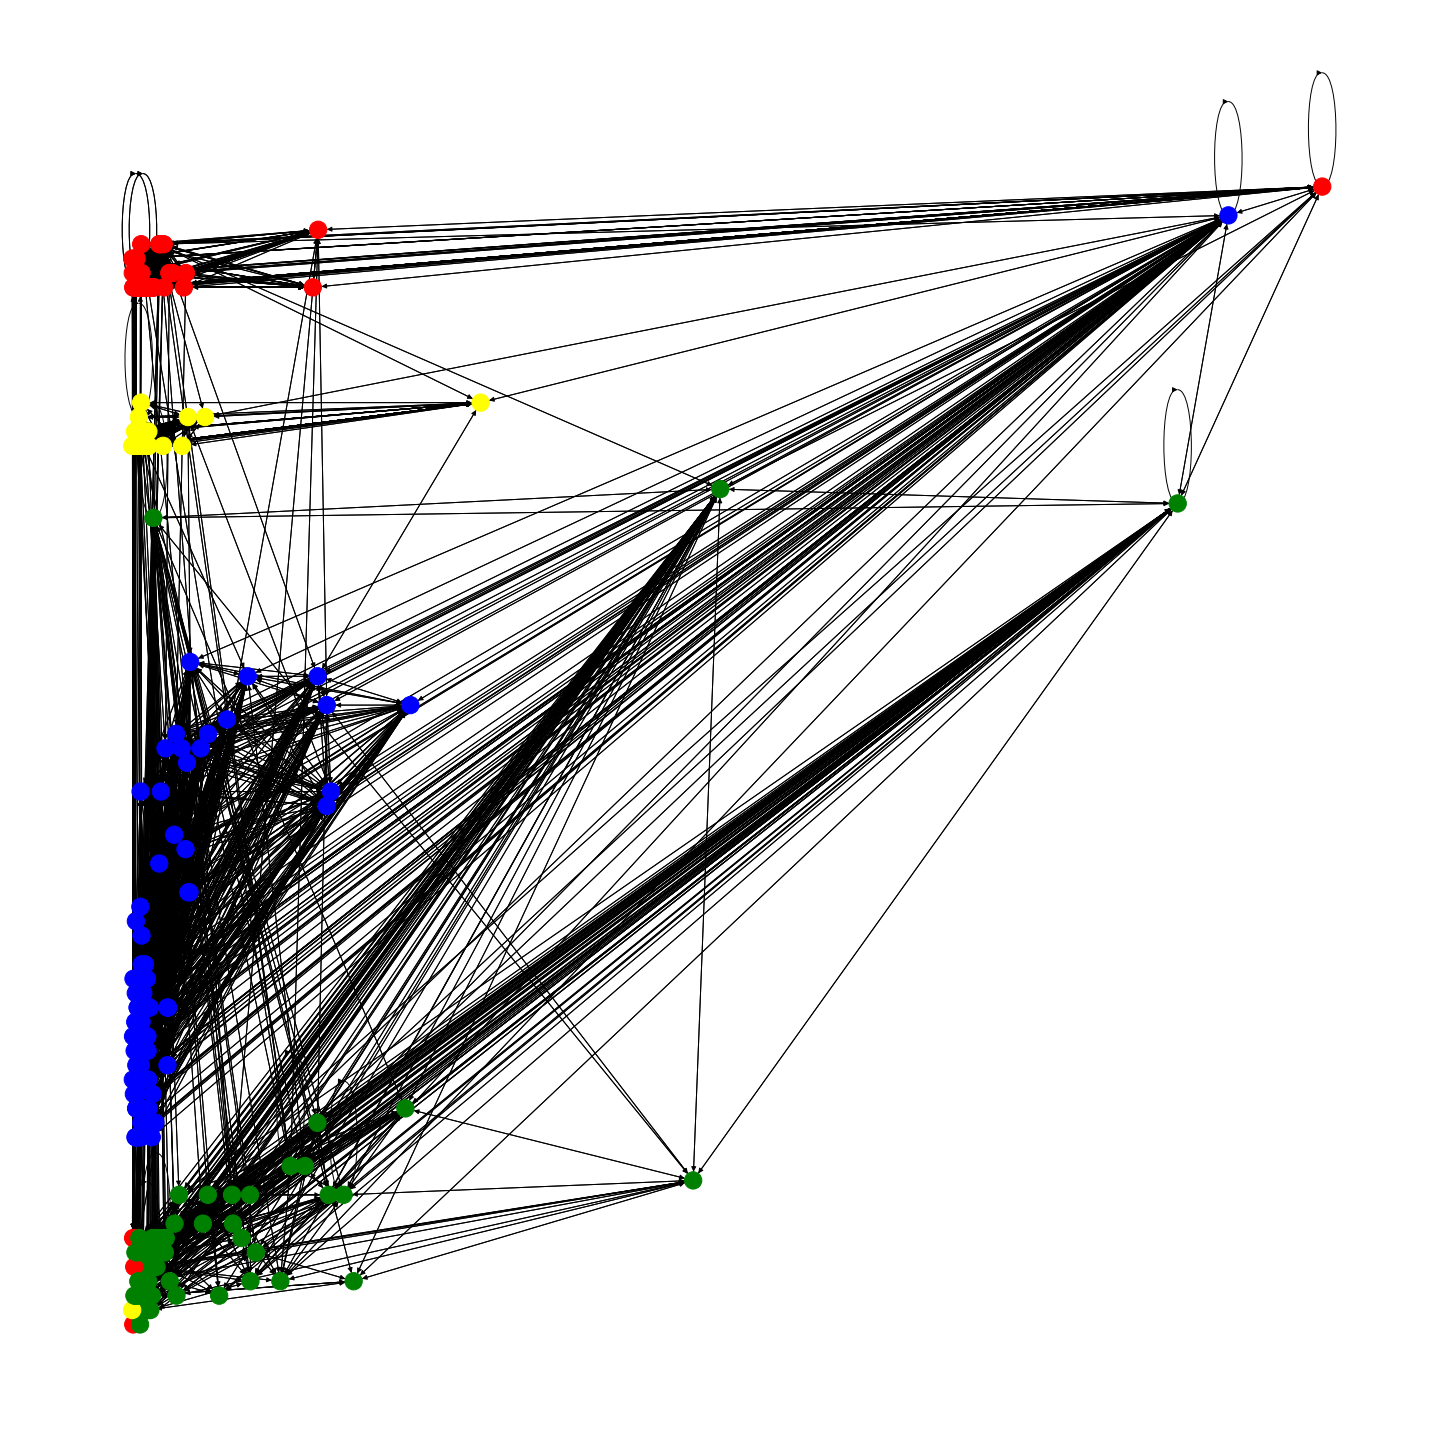

In [74]:
plt.figure(figsize=(20, 20))
nx.draw(nx_graph,
        StandardScaler().fit_transform(cities_nodes.sort_values('city')[['population', 'degree']]),
        node_color=colormap)